# Loading and normalizing CIFAR10 using `torchvision`

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [8]:
                                # 把灰度范围从0-255变换到0-1之间
transform = transforms.Compose([transforms.ToTensor(),
                                # 把0-1变换到(-1,1)，(0.5,0.5,0.5)和(0.5,0.5,0.5)分别是mean和std
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data',train=True,download=False,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4,
                                         shuffle=True,num_workers=0)
testloader = torch.utils.data.DataLoader(testset,batch_size=4,
                                         shuffle=True,num_workers=0)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


让我们来展示其中的一些训练图片。

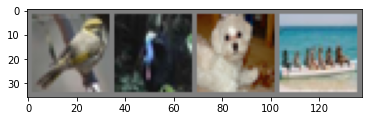

 bird  bird   dog  ship


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))#将若干幅图像拼成一幅图像
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Define a Convolutional Neural Network

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)#in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

# Define a loss function

使用分类交叉熵Cross-Entropy 作损失函数，动量SGD做优化器。

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

# Train the network on the training data

在数据迭代器上循环传给网络和优化器输入

In [29]:
for epoch in range(2):# loop over the dataset multiple times
    
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        # get the inputs
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()  #反向传播，计算当前梯度
        optimizer.step() #根据梯度更新网络参数
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %s] loss: %.3f' % 
                 (epoch + 1,i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

[1, 2000] loss: 1.422
[1, 4000] loss: 1.371
[1, 6000] loss: 1.356
[1, 8000] loss: 1.341
[1, 10000] loss: 1.291
[1, 12000] loss: 1.267
[2, 2000] loss: 1.199
[2, 4000] loss: 1.181
[2, 6000] loss: 1.190
[2, 8000] loss: 1.181
[2, 10000] loss: 1.169
[2, 12000] loss: 1.160
Finished Training


保存模型

In [30]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(),PATH)

# Test the network on the test data

从测试集中显示一个图像来熟悉。

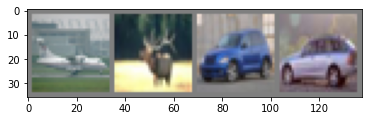

GroundTruth:  plane  deer   car   car


In [31]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

导入保存的模型

In [32]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [35]:
outputs = net(images)
print(outputs.shape)
_, predicted = torch.max(outputs,1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

torch.Size([4, 10])
Predicted:  plane  deer   car   car


看看网络在整个数据集上的表现。

In [36]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))        

Accuracy of the network on the 10000 test images: 61 %


哪些类表现良好，哪些类表现不佳:

In [37]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 75 %
Accuracy of  bird : 38 %
Accuracy of   cat : 30 %
Accuracy of  deer : 51 %
Accuracy of   dog : 70 %
Accuracy of  frog : 73 %
Accuracy of horse : 64 %
Accuracy of  ship : 74 %
Accuracy of truck : 70 %


# Training on GPU

首先定义下我们的设备为第一个可见的cuda设备。

In [38]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [39]:
net.to(device)
inputd, labels = data[0].to(device),data[1].to(device)